# 🚗 **License Plate Detection and Recognition Project** 🧠

---

## 🔍 **Project Overview**  
This project aims to develop a powerful **Deep Learning Model** for detecting and recognizing vehicle license plates.  
Leveraging the power of **YOLO (You Only Look Once)** for object detection and **EasyOCR** for text recognition, we aim to efficiently identify and read license plate information from vehicle images.

![Number Plate Detection](out-put\output-4.png "Data Collection Process")

---

## 🎯 **Project Goals**  
- 🚘 **Detect**: Identify the precise location of license plates in images.  
- 🔢 **Recognize**: Extract and read the license plate numbers.  
- 🏆 **Outcome**: Build a fine-tuned, robust model capable of detecting and recognizing diverse license plates with high accuracy.

---

## 🛠️ **Project Workflow**  

### 1️⃣ **Data Collection & Preprocessing**  
- 📸 Image dataset curated with varying license plates.  
- 🧹 Data cleaning and augmentation techniques applied for model generalization.  
- 🏎️ Handling variations like lighting, blur, angle distortions, and font styles.

### 2️⃣ **Model Development**  
- 🟢 **YOLO Object Detection** for efficient and real-time plate detection.  
- 📄 **EasyOCR** to accurately extract text from detected plates.  
- 🔧 Fine-tuning the YOLO model weights using transfer learning techniques.


### 3️⃣ **Deployment & Testing**  
- ⚙️ Deploying the trained model on real-world images.  
- 🧪 Testing with challenging scenarios (low light, angled plates).  
- 📈 Performance benchmarking.

---

## 🚀 **Outcomes & Future Enhancements**  
- 🏁 A highly accurate and fine-tuned model for detecting and reading license plates.  
- 🔍 Ready to be integrated into smart transportation systems for **automated toll collection, law enforcement, and vehicle tracking systems**.  

### ✨ **Future Plans**  
- 🧪 Further optimization for speed and performance.  
- 🌍 Expand to multilingual number plates using additional datasets.  
- 🔧 Deployment in Streamlit.

---



In [16]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import cv2
from ultralytics import YOLO
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [17]:
def create_yolo_directory_structure(base_path):
    """Create YOLO directory structure"""
    # Create main directories
    dirs = ['dataset/images/train', 'dataset/images/val', 
            'dataset/labels/train', 'dataset/labels/val']
    
    for dir_path in dirs:
        os.makedirs(os.path.join(base_path, dir_path), exist_ok=True)
    
    return os.path.join(base_path, 'dataset')

In [18]:
def get_image_dimensions(image_path):
    """This function get the image dimensions using OpenCV"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise Exception(f"Failed to load image: {image_path}")
        height, width = img.shape[:2]
        return width, height
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None, None

In [19]:
def convert_to_yolo_format(row, img_width, img_height):
    """Convert bounding box coordinates to YOLO format"""
    # YOLO format: <class> <x_center> <y_center> <width> <height>
    x_min, y_min = float(row['xmin']), float(row['ymin'])
    x_max, y_max = float(row['xmax']), float(row['ymax'])
    
    # Calculates center points and width/height
    x_center = ((x_min + x_max) / 2) / img_width
    y_center = ((y_min + y_max) / 2) / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    
    # Class 0 for license plate
    return f"0 {x_center} {y_center} {width} {height}"

In [20]:
def prepare_yolo_dataset(base_path, csv_path, images_path, train_split=0.8):
    """Prepare dataset in YOLO format"""
    # Read annotations
    df = pd.read_csv(csv_path)
    
    # Spliting data into train and validation
    train_imgs, val_imgs = train_test_split(df['img_id'].unique(), 
                                          train_size=train_split, 
                                          random_state=42)
    
    dataset_path = create_yolo_directory_structure(base_path)
    
    # Processing each image and creates corresponding label file
    for img_id in df['img_id'].unique():
        # Get full image path
        img_path = os.path.join(images_path, img_id)
        
        # Get actual image dimensions
        img_width, img_height = get_image_dimensions(img_path)
        
        if img_width is None or img_height is None:
            print(f"Skipping {img_id} due to image loading error")
            continue
            
        # Create YOLO format label
        img_annotations = df[df['img_id'] == img_id]
        yolo_lines = [convert_to_yolo_format(row, img_width, img_height) 
                     for _, row in img_annotations.iterrows()]
        
        # Determine if image goes to train or val set
        subset = 'train' if img_id in train_imgs else 'val'
        
        # Copy image
        dst_img = os.path.join(dataset_path, f"images/{subset}/{img_id}")
        shutil.copy2(img_path, dst_img)
        
        # Save label file
        label_path = os.path.join(dataset_path, f"labels/{subset}/{img_id.split('.')[0]}.txt")
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_lines))
    
    return dataset_path

In [30]:
# Get absolute path of your working directory
base_path = os.path.abspath("Soul Page")
dataset_path = os.path.join(base_path, "dataset")

# Print to verify paths
print("Base path:", base_path)
print("Dataset path:", dataset_path)

# Verify if directories exist
print("\nChecking directories:")
print(f"Images train path exists: {os.path.exists(os.path.join(dataset_path, 'images/train'))}")
print(f"Images val path exists: {os.path.exists(os.path.join(dataset_path, 'images/val'))}")
print(f"Labels train path exists: {os.path.exists(os.path.join(dataset_path, 'labels/train'))}")
print(f"Labels val path exists: {os.path.exists(os.path.join(dataset_path, 'labels/val'))}")

Base path: d:\Desktop\Soul page\Soul Page
Dataset path: d:\Desktop\Soul page\Soul Page\dataset

Checking directories:
Images train path exists: True
Images val path exists: True
Labels train path exists: True
Labels val path exists: True


In [31]:
def create_yaml_file(dataset_path, base_path):
    """Create YAML configuration file for YOLOv8"""
    yaml_content = f"""
path: {dataset_path}  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')

# Classes
names:
  0: license_plate
"""
    
    yaml_path = os.path.join(base_path, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    return yaml_path

In [32]:
# Path configurations
base_path = "Soul Page" # just to be sure 
csv_path = "Licplatesdetection_train.csv"
images_path = "license_plates_detection_train"

# Prepare dataset
dataset_path = prepare_yolo_dataset(base_path, csv_path, images_path)
yaml_path = create_yaml_file(dataset_path, base_path)

# Lets call our pretrained model 

In [13]:
model = YOLO('yolov8n.pt')  # Am using yolov8 nano beacause its light weight and use less resources


100%|██████████| 6.25M/6.25M [00:00<00:00, 10.5MB/s]


In [ ]:
# Train the model
model.train(data='Soul Page\dataset.yaml', epochs=20, imgsz=640)

Ultralytics 8.3.72  Python-3.11.6 torch-2.6.0+cpu CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Soul Page\dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 10.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning D:\Desktop\Soul page\Soul Page\dataset\labels\train... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:05<00:00, 122.22it/s]


train: New cache created: D:\Desktop\Soul page\Soul Page\dataset\labels\train.cache


val: Scanning D:\Desktop\Soul page\Soul Page\dataset\labels\val... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:01<00:00, 127.84it/s]


val: New cache created: D:\Desktop\Soul page\Soul Page\dataset\labels\val.cache
Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.178      2.313       1.08         36        640: 100%|██████████| 45/45 [59:20<00:00, 79.12s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [02:30<00:00, 25.01s/it]


                   all        180        180          1     0.0351       0.87      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G       1.18      1.431      1.034         17        640: 100%|██████████| 45/45 [2:25:23<00:00, 193.85s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [02:14<00:00, 22.42s/it]


                   all        180        180      0.971      0.921      0.977      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.181      1.244      1.039         25        640: 100%|██████████| 45/45 [46:25<00:00, 61.90s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:31<00:00, 15.20s/it]


                   all        180        180      0.969      0.863      0.935      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.155      1.118      1.039         28        640: 100%|██████████| 45/45 [57:03<00:00, 76.07s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:43<00:00, 17.25s/it]


                   all        180        180      0.961      0.948      0.974      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.038     0.9306     0.9901         26        640:  67%|██████▋   | 30/45 [1:51:37<1:25:37, 342.48s/it]

### ⏱️ Training Challenges & Decision  
It took **5+ hours** to train just **4 epochs** due to the absence of a GPU on my local machine. 🚫💻⚡  
Given the time constraints and performance limitations, I have decided to stop the training process and proceed directly to **testing the current results** to evaluate the model's performance. 🧪✅  

### 🏋️‍♂️ Training Batch Results (After 5 Epochs)  
Below are the training batch results obtained after just 5 epochs due to time constraints:  

![Batch Result](runs\detect\train3\train_batch2.jpg "Detection Result")


### 🧪 Let's Test on Our Test Data  
Now that training is complete, it's time to test the model on our test dataset to evaluate its performance. We'll observe how well the model detects and recognizes license plates from real-world examples.  




image 1/1 d:\Desktop\Soul page\test\904.jpg: 384x640 1 license_plate, 1531.8ms
Speed: 133.0ms preprocess, 1531.8ms inference, 48.4ms postprocess per image at shape (1, 3, 384, 640)


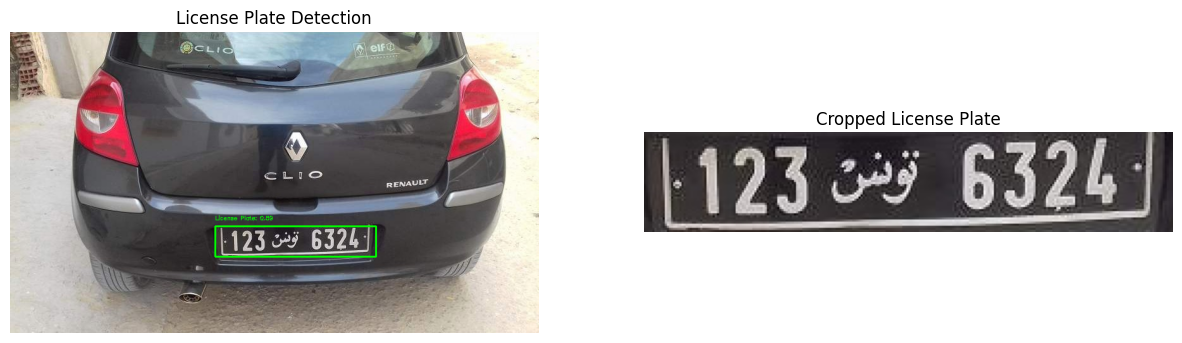

In [33]:
def detect_license_plates(image_path):
    """
    Detects license plates in an image using a pre-trained YOLO model,
    draws bounding boxes around the detected plates,
    and crops the detected plates for further processing.

    Parameters:
    -----------
    image_path : str
        The file path to the image in which license plates are to be detected.

    Returns:
    --------
    tuple
        A tuple containing two elements:
        - result_image : numpy.ndarray
            The original image with bounding boxes drawn around the detected license plates.
        - cropped_plates : list of numpy.ndarray
            A list of cropped images, each containing a detected license plate.

    Notes:
    ------
    - The function uses a YOLO model loaded from a specified
      path to perform object detection.
    - The confidence threshold for detection is set to 0.5.
    - The function displays the original image with detections and 
      the first cropped license plate using matplotlib.
    """

    # Load the trained model
    model = YOLO(r'D:\Desktop\Soul page\runs\detect\train3\weights\best.pt')
    
    # Run inference
    results = model(image_path, conf=0.5)
    
    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create a copy for drawing
    result_image = image_rgb.copy()
    
    # List to store cropped plates
    cropped_plates = []
    
    # Draw bounding boxes and crop plates
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get box coordinates
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            # Draw rectangle
            cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add confidence score
            conf = box.conf[0]
            label = f'License Plate: {conf:.2f}'
            cv2.putText(result_image, label, (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
            
            # Crop the license plate
            plate = image_rgb[y1:y2, x1:x2]
            cropped_plates.append(plate)
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    # Show original image with detections
    plt.subplot(1, 2, 1)
    plt.imshow(result_image)
    plt.axis('off')
    plt.title('License Plate Detection')
    
    # Show cropped plate(s)
    if cropped_plates:
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_plates[0])  # Show first plate if multiple detected
        plt.axis('off')
        plt.title('Cropped License Plate')
    
    plt.show()
    
    return result_image, cropped_plates

# Usage
image_path = 'test\904.jpg'
full_image, cropped_plates = detect_license_plates(image_path)


## 🔍 Moving to OCR Model  

Since I don't have access to a GPU or sufficient resources to train an OCR model from scratch, I'm using **EasyOCR** for license plate text extraction.  

**Why EasyOCR?**  
- 🛠️ Pretrained on multiple languages  
- ⚡ Lightweight and easy to use  
- 🚀 No need for extensive computational power  

Let's see how it performs on the detected license plates!  



image 1/1 d:\Desktop\Soul page\test\904.jpg: 384x640 1 license_plate, 1553.0ms
Speed: 19.0ms preprocess, 1553.0ms inference, 21.0ms postprocess per image at shape (1, 3, 384, 640)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


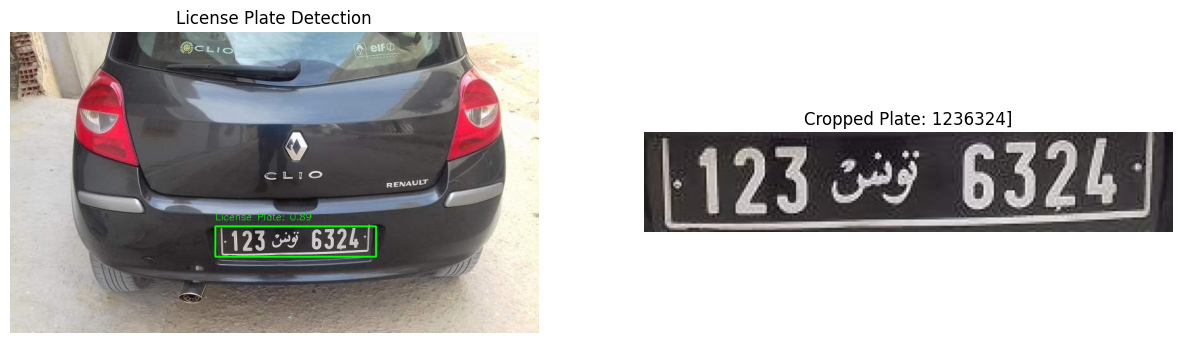

Recognized License Plate Texts: ['1236324]']


In [ ]:
import easyocr

def detect_license_plates_and_recognize_text(image_path):
    """
    Detects license plates in an image using a YOLO model, crops the detected plates, and recognizes text using EasyOCR.

    Parameters:
    -----------
    image_path : str
        Path to the image file for license plate detection and text recognition.

    Returns:
    --------
    tuple
        A tuple containing:
        - result_image (numpy.ndarray): Image with bounding boxes drawn around detected plates.
        - cropped_plates (list): List of cropped license plate images.
        - recognized_texts (list): List of recognized text strings from the plates.
    """
    # Load the trained model
    model = YOLO(r'D:\Desktop\Soul page\runs\detect\train3\weights\best.pt')

    # Run inference
    results = model(image_path, conf=0.5)

    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a copy for drawing
    result_image = image_rgb.copy()

    # Initialize EasyOCR Reader
    reader = easyocr.Reader(['en'])

    # List to store cropped plates and recognized texts
    cropped_plates = []
    recognized_texts = []

    # Draw bounding boxes and crop plates
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get box coordinates
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            # Draw rectangle
            cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add confidence score
            conf = box.conf[0]
            label = f'License Plate: {conf:.2f}'
            cv2.putText(result_image, label, (x1, y1 - 10), 
                         cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            # Crop the license plate
            plate = image_rgb[y1:y2, x1:x2]
            cropped_plates.append(plate)

            # Perform OCR on the cropped plate
            if plate.size > 0:
                plate_gray = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY)  # Convert to grayscale for better OCR results
                result = reader.readtext(plate_gray)

                # Extract and store recognized text
                recognized_text = ''.join([text[1] for text in result])
                recognized_texts.append(recognized_text)

    # Display results
    plt.figure(figsize=(15, 5))

    # Show original image with detections
    plt.subplot(1, 2, 1)
    plt.imshow(result_image)
    plt.axis('off')
    plt.title('License Plate Detection')

    # Show cropped plate(s) and detected text if available
    if cropped_plates:
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_plates[0])  # Show first plate if multiple detected
        plt.axis('off')
        plt.title(f'Cropped Plate: {recognized_texts[0]}' if recognized_texts else "No Text Detected")

    plt.show()

    return result_image, cropped_plates, recognized_texts


# Usage
image_path = 'test/904.jpg'
full_image, cropped_plates, recognized_texts = detect_license_plates_and_recognize_text(image_path)

# Output recognized text
print("Recognized License Plate Texts:", recognized_texts)



image 1/1 d:\Desktop\Soul page\test\905.jpg: 640x480 1 license_plate, 1095.0ms
Speed: 33.0ms preprocess, 1095.0ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 480)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


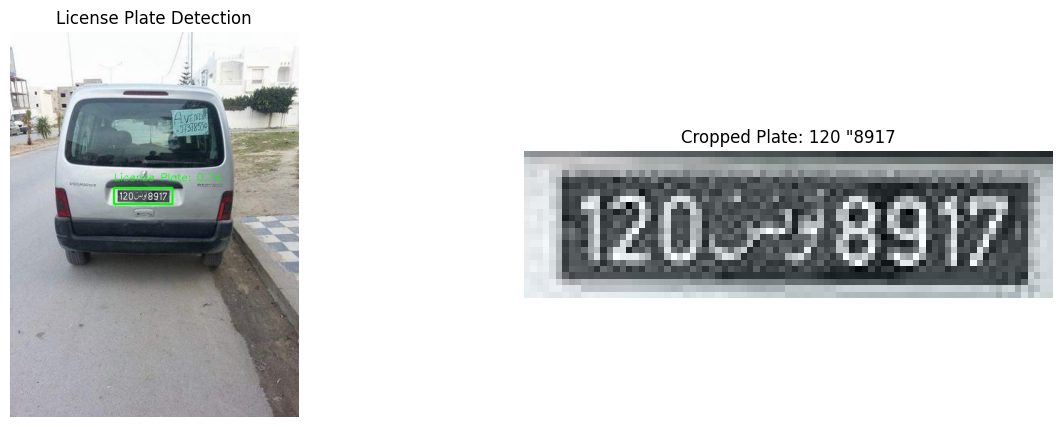

Recognized License Plate Texts: ['120 "8917']


In [15]:
image_path = 'test/905.jpg'
full_image, cropped_plates, recognized_texts = detect_license_plates_and_recognize_text(image_path)

# Output recognized text
print("Recognized License Plate Texts:", recognized_texts)